# 1. Data Collection for Index

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Popular market indices
indices = {
    'S&P 500': '^GSPC',
    'Dow Jones': '^DJI',
    'NASDAQ': '^IXIC',
    'Russell 2000': '^RUT',
    'FTSE 100': '^FTSE',
    'Nikkei 225': '^N225',
    'DAX': '^GDAXI',
    'Hang Seng': '^HSI'
}

# Choose your index
index_name = 'S&P 500'
ticker = indices[index_name]

# Download index data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data

data = yf.download(ticker, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
print(f"Downloaded {len(data)} days of {index_name} data")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print("\nFirst few rows:")
print(data.head())
print("\nLast few rows:")
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Downloaded 1254 days of S&P 500 data
Date range: 2020-10-16 00:00:00 to 2025-10-14 00:00:00

First few rows:
Price             Close         High          Low         Open      Volume
Date                                                                      
2020-10-16  3483.810059  3515.760010  3480.449951  3493.500000  4688030000
2020-10-19  3426.919922  3502.419922  3419.929932  3493.659912  4091080000
2020-10-20  3443.120117  3476.929932  3435.649902  3439.379883  3917850000
2020-10-21  3435.560059  3464.860107  3433.060059  3439.909912  4103960000
2020-10-22  3453.489990  3460.530029  3415.340088  3438.500000  4172060000

Last few rows:
Price             Close         High          Low         Open      Volume
Date                                                                      
2025-10-08  6753.720215  6755.640137  6718.089844  6723.870117  5383130000
2025-10-09  6735.109863  6764.580078  6716.169922  6760.500000  5385020000
2025-10-10  6552.509766  6762.399902  6550.779785 

# 2. Data Cleaning

In [30]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Handle missing values (forward fill then backward fill)
data = data.fillna(method='ffill').fillna(method='bfill')

# Remove duplicates
data = data[~data.index.duplicated(keep='first')]

# Check data quality
print("\nBasic statistics:")
print(data.describe())

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=50, min_samples=5)
# eps=50: Maximum distance between two points to be considered neighbors (epsilon/radius) If two points are within $50 apart (in this case, $50 in stock price), they can be in the same cluster
# A point needs at least 5 neighbors within eps distance to be considered a "core point"
clusters = dbscan.fit_predict(data[['Close']].values.reshape(-1, 1))
print("\nOutliers in Close price:")
outliers = data[clusters == -1]
print(f"Found {len(outliers)} outliers")
# For indices, we typically don't remove outliers as they represent real market events
# (crashes, rallies, etc.)


Missing values:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Basic statistics:
Price        Close         High          Low         Open        Volume
count  1254.000000  1254.000000  1254.000000  1254.000000  1.254000e+03
mean   4722.077656  4747.346469  4693.129056  4720.999045  4.392630e+09
std     829.108214   828.893055   828.073324   829.073049  9.745376e+08
min    3269.959961  3304.929932  3233.939941  3277.169922  0.000000e+00
25%    4098.027466  4126.737671  4071.672424  4091.087463  3.797838e+09
50%    4460.140137  4479.824951  4436.514893  4458.550049  4.226375e+09
75%    5417.877319  5462.280151  5389.732544  5421.057617  4.802075e+09
max    6753.720215  6764.580078  6718.089844  6760.500000  9.976520e+09

Outliers in Close price:
Found 4 outliers


# 3. Feature Engineering for Index



In [31]:
# Create technical indicators
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data['MA_200'] = data['Close'].rolling(window=200).mean()

# Moving Average Crossovers
data['MA_5_20_Diff'] = data['MA_5'] - data['MA_20']
data['MA_50_200_Diff'] = data['MA_50'] - data['MA_200']

# Volatility
data['Volatility_10'] = data['Returns'].rolling(window=10).std()
data['Volatility_20'] = data['Returns'].rolling(window=20).std()
data['Volatility_50'] = data['Returns'].rolling(window=50).std()

# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI_14'] = calculate_rsi(data['Close'], window=14)
data['RSI_7'] = calculate_rsi(data['Close'], window=7)

# MACD
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

# Bollinger Bands
data['BB_Middle'] = data['Close'].rolling(window=20).mean()
data['BB_Std'] = data['Close'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['BB_Std']
data['BB_Lower'] = data['BB_Middle'] - 2 * data['BB_Std']
data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']
data['BB_Position'] = (data['Close'] - data['BB_Lower']) / (data['BB_Upper'] - data['BB_Lower'])

# Volume features (if available)
if 'Volume' in data.columns:
    data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_20']
    data['Volume_Change'] = data['Volume'].pct_change()

# Price momentum
data['Momentum_5'] = data['Close'] - data['Close'].shift(5)
data['Momentum_10'] = data['Close'] - data['Close'].shift(10)
data['Momentum_20'] = data['Close'] - data['Close'].shift(20)

# Rate of Change (ROC)
data['ROC_5'] = ((data['Close'] - data['Close'].shift(5)) / data['Close'].shift(5)) * 100
data['ROC_10'] = ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)) * 100

# Average True Range (ATR) - Volatility measure
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
data['ATR_14'] = true_range.rolling(14).mean()

# Stochastic Oscillator
def calculate_stochastic(data, window=14):
    low_min = data['Low'].rolling(window=window).min()
    high_max = data['High'].rolling(window=window).max()
    k = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=3).mean()
    return k, d

data['Stochastic_K'], data['Stochastic_D'] = calculate_stochastic(data)

# Day of week effect (indices show patterns based on weekday)
data['DayOfWeek'] = data.index.dayofweek
data['IsMonday'] = (data['DayOfWeek'] == 0).astype(int)
data['IsFriday'] = (data['DayOfWeek'] == 4).astype(int)

# Month effect
data['Month'] = data.index.month
data['IsJanuary'] = (data['Month'] == 1).astype(int)

# Lag features (previous days' prices)
for i in range(1, 6):
    data[f'Close_Lag_{i}'] = data['Close'].shift(i)
    data[f'Returns_Lag_{i}'] = data['Returns'].shift(i)

# High-Low range
data['HL_Range'] = data['High'] - data['Low']
data['HL_Range_Pct'] = (data['HL_Range'] / data['Close']) * 100

# Open-Close relationship
data['OC_Diff'] = data['Close'] - data['Open']
data['OC_Diff_Pct'] = (data['OC_Diff'] / data['Open']) * 100

# Target variable (next day's close price)
data['Target'] = data['Close'].shift(-1)

# Also create binary classification target (up/down)
data['Target_Direction'] = (data['Target'] > data['Close']).astype(int)
data = data.replace([np.inf, -np.inf], np.nan)
# Drop rows with NaN values created by rolling windows and shifts
data_clean = data.dropna()

print("\nFinal dataset shape:", data_clean.shape)
print(f"Features: {data_clean.shape[1]} columns")
print(f"Samples: {data_clean.shape[0]} rows")
print("\nFeature columns:")
print(data_clean.columns.tolist())


Final dataset shape: (1053, 62)
Features: 62 columns
Samples: 1053 rows

Feature columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Log_Returns', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'MA_5_20_Diff', 'MA_50_200_Diff', 'Volatility_10', 'Volatility_20', 'Volatility_50', 'RSI_14', 'RSI_7', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'MACD_Histogram', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Volume_MA_20', 'Volume_Ratio', 'Volume_Change', 'Momentum_5', 'Momentum_10', 'Momentum_20', 'ROC_5', 'ROC_10', 'ATR_14', 'Stochastic_K', 'Stochastic_D', 'DayOfWeek', 'IsMonday', 'IsFriday', 'Month', 'IsJanuary', 'Close_Lag_1', 'Returns_Lag_1', 'Close_Lag_2', 'Returns_Lag_2', 'Close_Lag_3', 'Returns_Lag_3', 'Close_Lag_4', 'Returns_Lag_4', 'Close_Lag_5', 'Returns_Lag_5', 'HL_Range', 'HL_Range_Pct', 'OC_Diff', 'OC_Diff_Pct', 'Target', 'Target_Direction']


# 4. Data Splitting

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for modeling
feature_columns = [col for col in data_clean.columns 
                   if col not in ['Target', 'Target_Direction', 'Adj Close']]

# Remove some redundant columns if needed
exclude_cols = ['EMA_12', 'EMA_26', 'BB_Std']  # Keep derivatives but not intermediates
feature_columns = [col for col in feature_columns if col not in exclude_cols]

print(f"\nUsing {len(feature_columns)} features for modeling")

X = data_clean[feature_columns]
y = data_clean['Target']

# Time series split (important for index data - don't shuffle!)
# Use 70% for training, 15% for validation, 15% for testing
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+val_size:]

print(f"\nTraining set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)


Using 57 features for modeling

Training set: 737 samples (2021-08-03 00:00:00 to 2024-07-10 00:00:00)
Validation set: 157 samples (2024-07-11 00:00:00 to 2025-02-25 00:00:00)
Test set: 159 samples (2025-02-26 00:00:00 to 2025-10-13 00:00:00)


# 5. Model Training

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Dictionary to store models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
    
    # Direction accuracy (did we predict up/down correctly?)
    direction_actual = (y_val.values > y_val.index.to_series().map(data_clean['Close']).values).astype(int)
    direction_pred = (y_val_pred > y_val.index.to_series().map(data_clean['Close']).values).astype(int)
    direction_accuracy = np.mean(direction_actual == direction_pred) * 100
    
    results[name] = {
        'model': model,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Direction_Accuracy': direction_accuracy
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Direction Accuracy: {direction_accuracy:.2f}%")

# Find best model based on RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = results[best_model_name]['model']
print(f"\n{'='*50}")
print(f"Best model based on RMSE: {best_model_name}")
print(f"{'='*50}")



Training Linear Regression...
Linear Regression:
  RMSE: 55.4530
  MAE: 42.6530
  R²: 0.9421
  MAPE: 0.74%
  Direction Accuracy: 45.86%

Training Ridge Regression...
Ridge Regression:
  RMSE: 53.1790
  MAE: 40.1771
  R²: 0.9467
  MAPE: 0.70%
  Direction Accuracy: 44.59%

Training Lasso Regression...
Lasso Regression:
  RMSE: 52.0033
  MAE: 39.1974
  R²: 0.9491
  MAPE: 0.68%
  Direction Accuracy: 47.77%

Training ElasticNet...
ElasticNet:
  RMSE: 53.8999
  MAE: 41.5501
  R²: 0.9453
  MAPE: 0.72%
  Direction Accuracy: 42.68%

Training Random Forest...
Random Forest:
  RMSE: 346.9274
  MAE: 294.0751
  R²: -1.2667
  MAPE: 4.96%
  Direction Accuracy: 45.86%

Training Gradient Boosting...
Gradient Boosting:
  RMSE: 395.3041
  MAE: 341.9612
  R²: -1.9430
  MAPE: 5.77%
  Direction Accuracy: 47.13%

Training XGBoost...
XGBoost:
  RMSE: 391.1878
  MAE: 338.9507
  R²: -1.8820
  MAPE: 5.72%
  Direction Accuracy: 44.59%

Best model based on RMSE: Lasso Regression


# 6.Hyperparameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Tune the best performing model
print(f"\nTuning {best_model_name}...")

if 'XGBoost' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    model_to_tune = XGBRegressor(random_state=42)
    
elif 'Random Forest' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model_to_tune = RandomForestRegressor(random_state=42, n_jobs=-1)
    
elif 'Gradient Boosting' in best_model_name:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    model_to_tune = GradientBoostingRegressor(random_state=42)
else:
    # For linear models, simpler tuning
    if 'Ridge' in best_model_name:
        param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
        model_to_tune = Ridge()
    elif 'Lasso' in best_model_name:
        param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
        model_to_tune = Lasso()
    else:
        print("No tuning needed for Linear Regression")
        model_to_tune = None

if model_to_tune is not None:
    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    grid_search = GridSearchCV(
        model_to_tune, param_grid, cv=tscv,
        scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {-grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_


Tuning Lasso Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'alpha': 0.1}
Best cross-validation score: 5522.5539


# 7. Final Validation on Test Set



In [36]:
# Predict on test set
y_test_pred = best_model.predict(X_test_scaled)

# Calculate final metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Direction accuracy
direction_actual_test = (y_test.values > y_test.index.to_series().map(data_clean['Close']).values).astype(int)
direction_pred_test = (y_test_pred > y_test.index.to_series().map(data_clean['Close']).values).astype(int)
test_direction_accuracy = np.mean(direction_actual_test == direction_pred_test) * 100

print("\n" + "="*60)
print(f"FINAL TEST SET PERFORMANCE - {index_name}")
print("="*60)
print(f"Model: {best_model_name}")
print(f"Test Period: {y_test.index[0]} to {y_test.index[-1]}")
print(f"\nPrice Prediction Metrics:")
print(f"  RMSE: {test_rmse:.2f} points")
print(f"  MAE: {test_mae:.2f} points")
print(f"  R²: {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"\nDirection Prediction:")
print(f"  Accuracy: {test_direction_accuracy:.2f}%")
print(f"  (Correct up/down predictions)")
print("="*60)


FINAL TEST SET PERFORMANCE - S&P 500
Model: Lasso Regression
Test Period: 2025-02-26 00:00:00 to 2025-10-13 00:00:00

Price Prediction Metrics:
  RMSE: 75.86 points
  MAE: 49.97 points
  R²: 0.9690
  MAPE: 0.86%

Direction Prediction:
  Accuracy: 50.94%
  (Correct up/down predictions)


# 8. Comprehensive Visualization


📈 Creating visualizations...


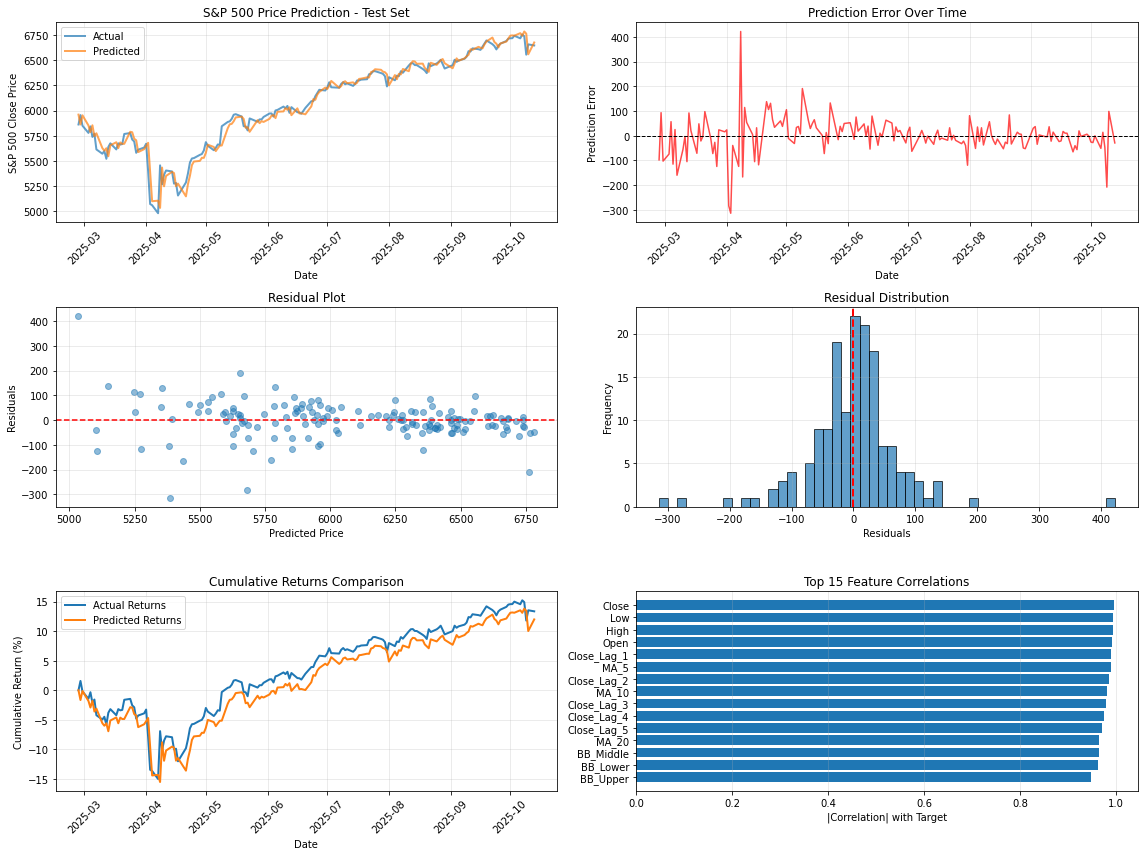


✅ Visualization saved as 'S&P_500_model_evaluation.png'


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n📈 Creating visualizations...")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# 1. Predictions vs Actual
ax1 = plt.subplot(3, 2, 1)
# ✅ FIX: Convert index to list or array
plt.plot(y_test.index.to_list(), y_test.values, label='Actual', linewidth=2, alpha=0.7)
plt.plot(y_test.index.to_list(), y_test_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Date')
plt.ylabel(f'{index_name} Close Price')
plt.title(f'{index_name} Price Prediction - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Prediction Error over time
ax2 = plt.subplot(3, 2, 2)
errors = y_test.values - y_test_pred
# ✅ FIX: Convert index to list
plt.plot(y_test.index.to_list(), errors, alpha=0.7, color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title('Prediction Error Over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3. Residual plot
ax3 = plt.subplot(3, 2, 3)
plt.scatter(y_test_pred, errors, alpha=0.5)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

# 4. Residual distribution
ax4 = plt.subplot(3, 2, 4)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 5. Cumulative Returns Comparison
ax5 = plt.subplot(3, 2, 5)
actual_returns = (y_test.values / y_test.values[0] - 1) * 100
pred_returns = (y_test_pred / y_test_pred[0] - 1) * 100
# ✅ FIX: Convert index to list
plt.plot(y_test.index.to_list(), actual_returns, label='Actual Returns', linewidth=2)
plt.plot(y_test.index.to_list(), pred_returns, label='Predicted Returns', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 6. Feature Importance
ax6 = plt.subplot(3, 2, 6)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    plt.barh(range(len(feature_importance)), feature_importance['Importance'].values)
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'].values)
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
else:
    # Calculate correlations manually
    correlations_dict = {}
    for col in feature_columns:
        try:
            x_vals = X_train[col].values
            y_vals = y_train.values
            corr_matrix = np.corrcoef(x_vals, y_vals)
            corr = abs(corr_matrix[0, 1])
            if not np.isnan(corr):
                correlations_dict[col] = corr
        except:
            continue
    
    correlations = pd.Series(correlations_dict).sort_values(ascending=False).head(15)
    
    plt.barh(range(len(correlations)), correlations.values)
    plt.yticks(range(len(correlations)), correlations.index.values)
    plt.xlabel('|Correlation| with Target')
    plt.title('Top 15 Feature Correlations')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
filename = f'{index_name.replace(" ", "_")}_model_evaluation.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved as '{filename}'")

# 9. Model Saving

In [13]:
import joblib

# Save the model and scaler
model_filename = f'{index_name.replace(" ", "_")}_model.pkl'
scaler_filename = f'{index_name.replace(" ", "_")}_scaler.pkl'

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)
joblib.dump(feature_columns, f'{index_name.replace(" ", "_")}_features.pkl')

print(f"\nModel saved as '{model_filename}'")
print(f"Scaler saved as '{scaler_filename}'")

# To load later:
# loaded_model = joblib.load(model_filename)
# loaded_scaler = joblib.load(scaler_filename)
# loaded_features = joblib.load(f'{index_name.replace(" ", "_")}_features.pkl')


Model saved as 'S&P_500_model.pkl'
Scaler saved as 'S&P_500_scaler.pkl'


# 10. Making Predictions & Trading Simulation

In [38]:
# Function to make predictions on new data
def predict_next_day(latest_data, model, scaler, feature_columns):
    """
    Predict the next day's index value
    """
    features = latest_data[feature_columns].iloc[-1:].values
    features_scaled = scaler.transform(features)
    prediction = model.predict(features_scaled)[0]
    return prediction

# Make prediction for next day
latest_prediction = predict_next_day(data_clean, best_model, scaler, feature_columns)
current_price = data_clean['Close'].iloc[-1]
predicted_change = ((latest_prediction / current_price) - 1) * 100

print(f"\n{'='*60}")
print("NEXT DAY PREDICTION")
print(f"{'='*60}")
print(f"Index: {index_name}")
print(f"Current Close: {current_price:.2f}")
print(f"Predicted Next Close: {latest_prediction:.2f}")
print(f"Predicted Change: {predicted_change:+.2f}%")
print(f"Direction: {'UP ▲' if predicted_change > 0 else 'DOWN ▼'}")
print(f"{'='*60}")

# Simple backtesting on test set
def simple_backtest(actual_prices, predicted_prices, initial_capital=10000):
    """
    Simple backtesting: buy if prediction is up, sell if down
    """
    capital = initial_capital
    position = 0
    trades = []
    
    for i in range(len(predicted_prices)-1):
        current_price = actual_prices.iloc[i]
        next_actual = actual_prices.iloc[i+1]
        next_predicted = predicted_prices[i]
        
        # Trading signal
        if next_predicted > current_price and position == 0:
            # Buy signal
            position = capital / current_price
            capital = 0
            trades.append(('BUY', actual_prices.index[i], current_price, position))
        elif next_predicted < current_price and position > 0:
            # Sell signal
            capital = position * current_price
            trades.append(('SELL', actual_prices.index[i], current_price, capital))
            position = 0
    
    # Close any open position
    if position > 0:
        capital = position * actual_prices.iloc[-1]
    
    return capital, trades

final_capital, trades = simple_backtest(y_test, y_test_pred)
returns = ((final_capital / 10000) - 1) * 100
buy_hold_returns = ((y_test.iloc[-1] / y_test.iloc[0]) - 1) * 100

print(f"\nSIMPLE BACKTEST RESULTS (Test Period)")
print(f"{'='*60}")
print(f"Initial Capital: $10,000")
print(f"Final Capital: ${final_capital:,.2f}")
print(f"Strategy Returns: {returns:+.2f}%")
print(f"Buy & Hold Returns: {buy_hold_returns:+.2f}%")
print(f"Number of Trades: {len(trades)}")
print(f"{'='*60}")


NEXT DAY PREDICTION
Index: S&P 500
Current Close: 6654.72
Predicted Next Close: 6673.57
Predicted Change: +0.28%
Direction: UP ▲

SIMPLE BACKTEST RESULTS (Test Period)
Initial Capital: $10,000
Final Capital: $12,131.20
Strategy Returns: +21.31%
Buy & Hold Returns: +13.35%
Number of Trades: 82
